In [1]:
import os.path as osp
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import argparse
import torch
import pandas as pd
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid, Coauthor
from torch_geometric.data import Data
from graph_conv import GraphConv
from torch_geometric.utils import degree
from torch_sparse import SparseTensor
import torch_geometric.transforms as T
from sklearn.metrics import average_precision_score, roc_auc_score
import math
import time
import pdb
import numpy as np
import random
import copy
import argparse

In [2]:
class EarlyStopMonitor(object):
  def __init__(self, max_round=3, higher_better=True, tolerance=1e-10):
    self.max_round = max_round
    self.num_round = 0

    self.epoch_count = 0
    self.best_epoch = 0

    self.last_best = None
    self.higher_better = higher_better
    self.tolerance = tolerance

  def early_stop_check(self, curr_val):
    if not self.higher_better:
      curr_val *= -1
    if self.last_best is None:
      self.last_best = curr_val
    elif (curr_val - self.last_best) / np.abs(self.last_best) > self.tolerance:
      self.last_best = curr_val
      self.num_round = 0
      self.best_epoch = self.epoch_count
    else:
      self.num_round += 1

    self.epoch_count += 1

    return self.num_round >= self.max_round


In [3]:
class Data:
  def __init__(self, sources, destinations, timestamps, edge_idxs, labels):
    self.sources = sources
    self.destinations = destinations
    self.timestamps = timestamps
    self.edge_idxs = edge_idxs
    self.labels = labels
    self.n_interactions = len(sources)
    self.unique_nodes = set (sources) | set(destinations)
    self.n_unique_nodes = len(self.unique_nodes)
def get_data_node_classification(dataset_name, use_validation=False):
  ### Load data and train val test split
  graph_df = pd.read_csv('./data/ml_{}.csv'.format(dataset_name))
  edge_features = np.load('./data/ml_{}.npy'.format(dataset_name))
  node_features = np.load('./data/ml_{}_node.npy'.format(dataset_name))
  
  val_time, test_time = list(np.quantile(graph_df.ts, [0.70, 0.85]))
  sources = graph_df.u.values
  destinations = graph_df.i.values
  edge_idxs = graph_df.idx.values
  
  labels = graph_df.label.values
  timestamps = graph_df.ts.values
  
  
  random.seed(2020)

  train_mask = timestamps <= val_time if use_validation else timestamps <= test_time
  test_mask = timestamps > test_time
  val_mask = np.logical_and(timestamps <= test_time, timestamps > val_time) if use_validation else test_mask

  full_data = Data(sources, destinations, timestamps, edge_idxs, labels)

  train_data = Data(sources[train_mask], destinations[train_mask], timestamps[train_mask],
                    edge_idxs[train_mask], labels[train_mask])

  val_data = Data( sources[val_mask], destinations[val_mask], timestamps[val_mask],
                  edge_idxs[val_mask], labels[val_mask])

  test_data = Data( sources[test_mask], destinations[test_mask], timestamps[test_mask],
                   edge_idxs[test_mask], labels[test_mask])
  
  
  full_data.num_nodes = len(full_data.sources)
   
  node_id = full_data.labels
  full_data.x = np.arange(27085528).reshape(157474, 172)
  full_data.x = torch.tensor( full_data.x , dtype = torch.float32)
  full_data.y = torch.tensor(full_data.labels, dtype = torch.int64)
  idx =  len(full_data.edge_idxs)  
 
  full_data.edge_idxs = np.arange(idx).reshape(2, 78737)
  full_data.edge_idxs = torch.tensor( full_data.edge_idxs , dtype= torch.int64)
  
  return full_data, node_features, edge_features

In [4]:
parser = argparse.ArgumentParser('Mixup')
parser.add_argument('-d', '--data', type=str, help='Dataset name (eg. wikipedia or reddit)',default='wikipedia')
parser.add_argument('--mixup', action='store_true', help='Whether to have Mixup')
parser.add_argument('--use_validation', action='store_true', help='Whether to use a validation set')
args = parser.parse_args(args=[])


def idNode(data, id_new_value_old):
    data = copy.deepcopy(data)
    data.x = None
    data.y[data.val_id] = -1
    data.y[data.test_id] = -1
    data.y = data.y[id_new_value_old]

    data.train_id = None
    data.test_id = None
    data.val_id = None

    id_old_value_new = torch.zeros(id_new_value_old.shape[0], dtype = torch.long)
    id_old_value_new[id_new_value_old] = torch.arange(0, id_new_value_old.shape[0], dtype = torch.long)
    row = data.edge_idxs[0]
    col = data.edge_idxs[1]
    row = id_old_value_new[row]
    col = id_old_value_new[col]
    data.edge_idxs = torch.stack([row, col], dim=0)

    return data

def shuffleData(data):
    data = copy.deepcopy(data)
    id_new_value_old = np.arange(data.num_nodes)
    train_id_shuffle = copy.deepcopy(data.train_id)
    np.random.shuffle(train_id_shuffle)
    id_new_value_old[data.train_id] = train_id_shuffle
    data = idNode(data, id_new_value_old)

    return data, id_new_value_old

class Net(torch.nn.Module):
    def __init__(self, hidden_channels, in_channel, out_channel):
        super(Net, self).__init__()
        self.conv1 = GraphConv(in_channel, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(1 * hidden_channels, out_channel)
    def forward(self, x0, edge_index, edge_index_b, lam, id_new_value_old):
        
        x1 = self.conv1(x0, edge_index, x0)
        x1 = F.relu(x1)
        x1 = F.dropout(x1, p=0.4, training=self.training)

        x2 = self.conv2(x1, edge_index, x1)
        x2 = F.relu(x2)
        x2 = F.dropout(x2, p=0.4, training=self.training)
        
        x0_b = x0[id_new_value_old]
        x1_b = x1[id_new_value_old]
        x2_b = x2[id_new_value_old]

        x0_mix = x0 * lam + x0_b * (1 - lam)

        new_x1 = self.conv1(x0, edge_index, x0_mix)
        new_x1_b = self.conv1(x0_b, edge_index_b, x0_mix)
        new_x1 = F.relu(new_x1)
        new_x1_b = F.relu(new_x1_b)

        x1_mix = new_x1 * lam + new_x1_b * (1 - lam)
        x1_mix = F.dropout(x1_mix, p=0.4, training=self.training)

        new_x2 = self.conv2(x1, edge_index, x1_mix)
        new_x2_b = self.conv2(x1_b, edge_index_b, x1_mix)
        new_x2 = F.relu(new_x2)
        new_x2_b = F.relu(new_x2_b)

        x2_mix = new_x2 * lam + new_x2_b * (1 - lam)
        x2_mix = F.dropout(x2_mix, p=0.4, training=self.training)

        new_x3 = self.conv3(x2, edge_index, x2_mix)
        new_x3_b = self.conv3(x2_b, edge_index_b, x2_mix)
        new_x3 = F.relu(new_x3)
        new_x3_b = F.relu(new_x3_b)

        x3_mix = new_x3 * lam + new_x3_b * (1 - lam)
        x3_mix = F.dropout(x3_mix, p=0.4, training=self.training)

        x = x3_mix
        x = self.lin(x)
        return x.log_softmax(dim=-1)
    

# set random seed
SEED = 0
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
np.random.seed(SEED)  # Numpy module.
random.seed(SEED)  # Python random module.

#######
BATCH_SIZE = 157474
#########
DATA = args.data
data, node_features, edge_features= get_data_node_classification(DATA, use_validation= False)


# split data
node_id = np.arange(data.num_nodes)
np.random.shuffle(node_id)
data.train_id = node_id[:int(data.num_nodes * 0.6)]
data.val_id = node_id[int(data.num_nodes * 0.6):int(data.num_nodes * 0.8)]
data.test_id = node_id[int(data.num_nodes * 0.8):]

num_instance = len(data.train_id )
num_batch = math.ceil(num_instance / BATCH_SIZE)
print("num_batch",num_batch)
# define model

model = Net(hidden_channels=172, in_channel = node_features.shape[1], out_channel = 2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#model_loss_criterion = torch.nn.CrossEntropyLoss()

# train 
# func train one epoch
def train(data):
    pred_prob = np.zeros(len(data.sources))
    num_instance = len(data.sources)
    num_batch = math.ceil(num_instance / BATCH_SIZE)
    with torch.no_grad():
      model.eval()
      for k in range(num_batch):
        s_idx = k * BATCH_SIZE
        e_idx = min(num_instance, s_idx + BATCH_SIZE)
        pred_prob_batch = model(data.x, data.edge_idxs, data_b.edge_idxs, lam, id_new_value_old).sigmoid()
        pred_prob_batch = pred_prob_batch.argmax(dim=-1)
        pred_prob = pred_prob_batch.cpu().numpy()
        
    auc_roc = roc_auc_score(data.labels, pred_prob)
    return auc_roc
# test 
def test(data):
    model.eval()

    out = model(data.x, data.edge_idxs, data.edge_idxs, 1, np.arange(data.num_nodes))
    pred = out.argmax(dim=-1)
    correct = pred.eq(data.y)

    accs = []
    #A = np.array([data.train_id], [data.val_id], [data.test_id])
    accs = []
    for i in range(0,3):
        if i == 1:
            for id_ in [data.train_id]:
                 accs.append(correct[id_].sum().item() / id_.shape[0])
        elif i== 2:
            for id_ in [data.val_id]:
                 accs.append(correct[id_].sum().item() / id_.shape[0])
        else:
            for id_ in [data.test_id]:
                 accs.append(correct[id_].sum().item() / id_.shape[0])  
               
    return accs

val_aucs = []
train_losses = []

early_stopper = EarlyStopMonitor(max_round= 5)
for epoch in range(10):
    start_epoch = time.time()
    

model = model.train()
loss = 0
for epoch in range(1, 6):    
   for k in range(num_batch):
      s_idx = k * BATCH_SIZE
      e_idx = min(num_instance, s_idx + BATCH_SIZE)
      sources_batch = data.sources[s_idx: e_idx]
      labels_batch = data.labels[s_idx: e_idx]
      size = len(sources_batch)
      optimizer.zero_grad()
      data_b, id_new_value_old = shuffleData(data)
      lam = np.random.beta(4.0, 4.0)
      labels_batch_torch = torch.from_numpy(labels_batch).float()#.to(device)
      pred = model(data.x, data.edge_idxs, data_b.edge_idxs, lam, id_new_value_old).sigmoid()
      model_loss = F.nll_loss(pred[data.train_id], data.y[data.train_id]) * lam 
      #model_loss = model_loss_criterion(pred, labels_batch_torch)
      model_loss.backward()
      optimizer.step()
      loss  += model_loss.item()
      #loss.backward()
   train_losses.append(loss / num_batch)
############################
   val_auc = train(data)
   val_aucs.append(val_auc)
   print(f'Epoch {epoch}: train loss: {train_losses}, val auc: {val_auc}, time: {time.time() - start_epoch}')
   test_auc = test(data)
   print(f'test auc: {test_auc}') 
   print("-----------------------------------------------------------------------------------------------------")

num_batch 1
Epoch 1: train loss: [-0.05150127410888672], val auc: 0.4887033081454706, time: 16.9602689743042
test auc: [0.7432925861247817, 0.7396490411074891, 0.7466581997142403]
-----------------------------------------------------------------------------------------------------
Epoch 2: train loss: [-0.05150127410888672, -0.19259774684906006], val auc: 0.5, time: 36.278512954711914
test auc: [0.9983171932052707, 0.9986981922865247, 0.9986982060644547]
-----------------------------------------------------------------------------------------------------
Epoch 3: train loss: [-0.05150127410888672, -0.19259774684906006, -0.27552635967731476], val auc: 0.5, time: 55.85288906097412
test auc: [0.9983171932052707, 0.9986981922865247, 0.9986982060644547]
-----------------------------------------------------------------------------------------------------
Epoch 4: train loss: [-0.05150127410888672, -0.19259774684906006, -0.27552635967731476, -0.5461229830980301], val auc: 0.5, time: 75.509981

     ------------------- Loss ---------------


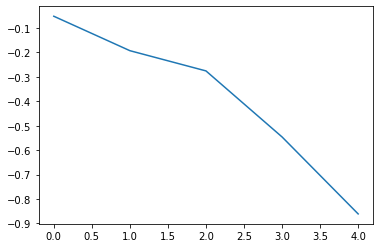

     -------------------val_aucs-------------


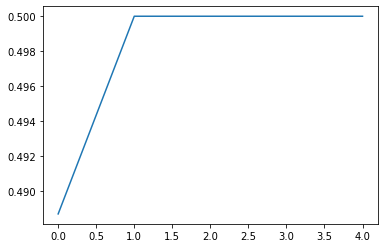

       -------------------test_auc-------------


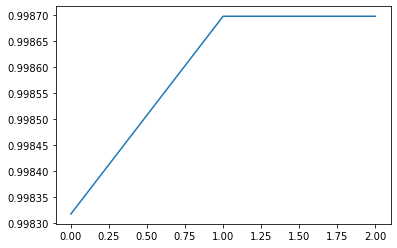

In [5]:
import matplotlib.pyplot as plt
print("     ------------------- Loss ---------------")
plt.plot(train_losses)
plt.show()
print("     -------------------val_aucs-------------")
plt.plot(val_aucs)
plt.show()
print("       -------------------test_auc-------------")
plt.plot(test_auc)
plt.show()

In [6]:
if all(i == 0 for i in data.labels.shape):
    # 👇️ this runs
    print('All elements in the list are 0')
else:
    print('Not all elements in the list are 0')

# 👇️ True
print(all(i == 0 for i in data.labels.shape))

Not all elements in the list are 0
False


In [7]:
is_all_zero = np.all((data.labels == 0))
if is_all_zero:
    print('Array contains only 0')
else:
    print('Array has non-zero items too')
    

Array has non-zero items too
